In [21]:
import datetime
import json
import random
import numpy as np
import matplotlib.pyplot as plt
from keras.models import Sequential
from keras.layers.core import Dense
from keras.layers.advanced_activations import PReLU
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'

In [22]:
#create a user defined grid of size m*n
def create_board(vertical,horizontal):
    board = [[1 for column in range(vertical)] for  cell in range(horizontal)]
    board = np.array(board)
    return board

In [23]:
board = create_board(6,6)
board

array([[1, 1, 1, 1, 1, 1],
       [1, 1, 1, 1, 1, 1],
       [1, 1, 1, 1, 1, 1],
       [1, 1, 1, 1, 1, 1],
       [1, 1, 1, 1, 1, 1],
       [1, 1, 1, 1, 1, 1]])

In [24]:
#define random points for obstacles except start and end points
def intialize_obstacles(start,end):
    obstacles = []
    limit = int((board.shape[0]*board.shape[1])/4)
    count = 0
    while(count!=limit):
        ran = np.random.randint((board.shape[0]*board.shape[1]))
        if(ran!=start and ran!=end and ran not in obstacles):
            obstacles.append(ran)
            count+=1
        else:
            continue
    return obstacles

In [25]:
#position obstacles
def position_obstacles(board,obstacles):
    horizontal = board.shape[0]
    vertical = board.shape[1]
    board = board.flatten()
    for i in obstacles:
        board[i] = 0
    board = np.reshape(board,(vertical,horizontal))
    return board

In [26]:
def multiplyList(l,col,row) :
    res = col*(l[0])+l[1]
    return res

In [27]:
start = [0,0]
end = [5,5]

vertical = 6
horizontal = 6

In [28]:
obstacles = intialize_obstacles(multiplyList(start,vertical,horizontal),multiplyList(end,vertical,horizontal))

In [29]:
board_with_obstacles = position_obstacles(board,obstacles)
board_with_obstacles = board_with_obstacles.astype(float)
board_with_obstacles

array([[1., 1., 1., 1., 1., 1.],
       [1., 1., 0., 0., 0., 1.],
       [1., 1., 1., 1., 1., 0.],
       [1., 0., 1., 1., 1., 1.],
       [0., 1., 1., 1., 0., 0.],
       [1., 1., 0., 1., 1., 1.]])

In [30]:
#reward matrix
rewards = np.full((horizontal,vertical),-100.)
rewards[end[0],end[1]]= 100
for i in range(len(board_with_obstacles)):
    for j in range(len(board_with_obstacles[0])):
        # print(i,j)
        if(board_with_obstacles[i][j]==1 and rewards[i][j]!=100):
            rewards[i][j]=-1

len(board_with_obstacles),len(board_with_obstacles[0]),rewards[end[0],end[1]]

(6, 6, 100.0)

In [31]:
rewards

array([[  -1.,   -1.,   -1.,   -1.,   -1.,   -1.],
       [  -1.,   -1., -100., -100., -100.,   -1.],
       [  -1.,   -1.,   -1.,   -1.,   -1., -100.],
       [  -1., -100.,   -1.,   -1.,   -1.,   -1.],
       [-100.,   -1.,   -1.,   -1., -100., -100.],
       [  -1.,   -1., -100.,   -1.,   -1.,  100.]])

In [32]:
class Grid_object(object):
    def __init__(self,grid, start_pos=(start[0], start[1])):
        self.grid = np.array(grid)
        horizontal, vertical = self.grid.shape
        self.target = (end[0], end[1])
        self.paths = [(r, c) for r in range(horizontal)
                      for c in range(vertical) if self.grid[r, c] == 1.0]
        self.paths.remove(self.target)
        self.Grid_reset(start_pos)

    def Grid_reset(self, pos):
        self.pos = pos
        self.grid = np.copy(self.grid)
        horizontal, vertical = self.grid.shape
        row, col = pos
        self.grid[row, col] = 0.5
        self.state = (row, col, 'start')
        self.min_reward = -0.5 * self.grid.size
        self.total_reward = 0
        self.visited = set()

    def UpdateState(self, action):
        horizontal, vertical = self.grid.shape
        horizontal, vertical, nmode = pos_row, pos_col, mode = self.state
        if self.grid[pos_row, pos_col] > 0.0:
            self.visited.add((pos_row, pos_col))
        valid_actions = self.valid_actions()
        if not valid_actions:
            nmode = 'blocked'
        elif action in valid_actions:
            nmode = 'valid'
            if action == 0:
                vertical -= 1
            elif action == 1:
                horizontal -= 1
            if action == 2:
                vertical += 1
            elif action == 3:
                horizontal += 1
        else:
            nmode = 'invalid'
        self.state = (horizontal, vertical, nmode)

    def get_reward(self):
        pos_row, pos_col, mode = self.state
        horizontal, vertical = self.grid.shape
        if pos_row == end[0] and pos_col == end[1]:
            return 1.0
        if mode == 'blocked':
            return self.min_reward - 1
        if (pos_row, pos_col) in self.visited:
            return -0.25
        if mode == 'invalid':
            return -0.75
        if mode == 'valid':
            return -0.04

    def act(self, action):
        self.UpdateState(action)
        reward = self.get_reward()
        self.total_reward += reward
        status = self.game_status()
        envstate = self.observe()
        return envstate, reward, status

    def observe(self):
        canvas = self.draw_env()
        envstate = canvas.reshape((1, -1))
        return envstate

    def draw_env(self):
        canvas = np.copy(self.grid)
        horizontal, vertical = self.grid.shape
        for r in range(horizontal):
            for c in range(vertical):
                if canvas[r, c] > 0.0:
                    canvas[r, c] = 1.0
        row, col, valid = self.state
        canvas[row, col] = 0.5
        return canvas

    def game_status(self):
        if self.total_reward < self.min_reward:
            return 'lose'
        pos_row, pos_col, mode = self.state
        horizontal, vertical = self.grid.shape
        if pos_row == horizontal - 1 and pos_col == vertical - 1:
            return 'win'
        return 'not_over'

    def valid_actions(self, cell=None):
        if cell is None:
            row, col, mode = self.state
        else:
            row, col = cell
        actions = [0, 1, 2, 3]
        horizontal, vertical = self.grid.shape
        if row == 0:
            actions.remove(1)
        elif row == horizontal - 1:
            actions.remove(3)
        if col == 0:
            actions.remove(0)
        elif col == vertical - 1:
            actions.remove(2)
        if row > 0 and self.grid[row - 1, col] == 0.0:
            actions.remove(1)
        if row < horizontal - 1 and self.grid[row + 1, col] == 0.0:
            actions.remove(3)
        if col > 0 and self.grid[row, col - 1] == 0:
            actions.remove(0)
        if col < vertical - 1 and self.grid[row, col + 1] == 0.0:
            actions.remove(2)
        return actions


In [33]:

def solve_grid(model, grid_object, pos, show_maze=False):
    action_lst = []
    grid_object.Grid_reset(pos)
    envstate = grid_object.observe()
    while True:
        prev_envstate = envstate
        q = model.predict(prev_envstate)
        action = np.argmax(q[0])
        action_lst.append(action)
        # print(action_lst)
        envstate, reward, game_status = grid_object.act(action)
        if game_status == 'win':
            return True,action_lst
        elif game_status == 'lose':
            return False

In [34]:
def completion_check(model, grid_object):
    for cell in grid_object.paths:
        if not grid_object.valid_actions(cell):
            return False
        if not solve_grid(model, grid_object, cell):
            return False
    return True

In [35]:
class Experience(object):

    def __init__(self, model, max_memory=100, discount=0.95):
        self.model = model
        self.max_memory = max_memory
        self.discount = discount
        self.memory = list()
        self.num_actions = model.output_shape[-1]

    def save_memory(self, episode):
        self.memory.append(episode)
        if len(self.memory) > self.max_memory:
            del self.memory[0]

    def predict(self, envstate):
        return self.model.predict(envstate)[0]

    def get_data(self, data_size=10):
        env_size = self.memory[0][0].shape[1]
        mem_size = len(self.memory)
        data_size = min(mem_size, data_size)
        inputs = np.zeros((data_size, env_size))
        targets = np.zeros((data_size, self.num_actions))
        for i, j in enumerate(np.random.choice(range(mem_size), data_size,
                                               replace=False)):
            envstate, action, reward, envstate_next, game_over = self.memory[j]
            inputs[i] = envstate
            targets[i] = self.predict(envstate)
            Q_sa = np.max(self.predict(envstate_next))
            if game_over:
                targets[i, action] = reward
            else:
                targets[i, action] = reward + self.discount * Q_sa
        return inputs, targets

In [36]:
def qtrain(model, grid, epsilon=0.1, **opt):
    n_epoch = opt.get('n_epoch', 1000)
    max_memory = opt.get('max_memory', 1000)
    data_size = opt.get('data_size', 50)
    weights_file = opt.get('weights_file', "model.h5")
    name = opt.get('name', 'model')
    start_time = datetime.datetime.now()
    if weights_file:
        try:
            print("loading weights from file: %s" % (weights_file,))
            model.load_weights(weights_file)
        except ValueError:
            print("Incompatible model - starting from new model.")
            pass
        except OSError:
            print("Model does not exist - starting from new model.")
            pass
    h5file = name + ".h5"
    json_file = name + ".json"
    grid_object = Grid_object(grid)
    experience = Experience(model, max_memory=max_memory)
    win_history = []
    hsize = grid_object.grid.size // 2
    win_rate = 0.0
    for epoch in range(n_epoch):
        loss = 0.0
        pos = random.choice(grid_object.paths)
        grid_object.Grid_reset(pos)
        game_over = False
        envstate = grid_object.observe()
        n_episodes = 0
        while not game_over:
            valid_actions = grid_object.valid_actions()
            if not valid_actions:
                break
            prev_envstate = envstate
            if np.random.rand() < epsilon:
                action = random.choice(valid_actions)
            else:
                action = np.argmax(experience.predict(prev_envstate))
            envstate, reward, game_status = grid_object.act(action)
            if game_status == 'win':
                win_history.append(1)
                game_over = True
            elif game_status == 'lose':
                win_history.append(0)
                game_over = True
            else:
                game_over = False
            episode = [prev_envstate, action, reward, envstate, game_over]
            experience.save_memory(episode)
            n_episodes += 1
            inputs, targets = experience.get_data(data_size=data_size)
            model.fit(inputs, targets, epochs=8, batch_size=16, verbose=0)
            loss = model.evaluate(inputs, targets, verbose=0)
        model.save_weights(h5file, overwrite=True)
        with open(json_file, "w") as outfile:
            json.dump(model.to_json(), outfile)
        if len(win_history) > hsize:
            win_rate = sum(win_history[-hsize:]) / hsize
        dt = datetime.datetime.now() - start_time
        t = format_time(dt.total_seconds())
        template = "Epoch: {:03d}/{:d} | Loss: {:.4f} | Episodes: {:d} | Win count: {:d} | Win rate: {:.3f} | Time: {}"
        print(template.format(epoch, n_epoch - 1, loss,
                              n_episodes, sum(win_history), win_rate, t))
        if win_rate > 0.9:
            epsilon = 0.05
        if win_rate==1:
          break
        if sum(win_history[-hsize:]) == hsize and completion_check(model,
                                                                   grid_object):
            print("Reached 100%% win rate at epoch: %d" % (epoch,))
            break
    model.save_weights(h5file, overwrite=True)
    with open(json_file, "w") as outfile:
        json.dump(model.to_json(), outfile)
    dt = datetime.datetime.now() - start_time
    seconds = dt.total_seconds()
    t = format_time(seconds)
    print('files: %s, %s' % (h5file, json_file))
    print("n_epoch: %d, max_mem: %d, data: %d, time: %s" %
          (epoch, max_memory, data_size, t))
    return seconds


In [37]:
def format_time(seconds):
    if seconds < 400:
        s = float(seconds)
        return "%.1f seconds" % (s,)
    elif seconds < 4000:
        m = seconds / 60.0
        return "%.2f minutes" % (m,)
    else:
        h = seconds / 3600.0
        return "%.2f hours" % (h,)


In [38]:
def deep_q_model(grid):
    model = Sequential()
    model.add(Dense(grid.size, input_shape=(grid.size,)))
    model.add(PReLU())
    model.add(Dense(64))
    model.add(PReLU())
    model.add(Dense(16))
    model.add(PReLU())
    model.add(Dense(4))
    model.compile(optimizer='adam', loss='mse')
    return model

In [39]:
grid = board_with_obstacles

In [40]:
model = deep_q_model(grid)
qtrain(model, grid)


loading weights from file: model.h5
Model does not exist - starting from new model.
Epoch: 000/999 | Loss: 0.0177 | Episodes: 82 | Win count: 0 | Win rate: 0.000 | Time: 218.4 seconds
Epoch: 001/999 | Loss: 0.0073 | Episodes: 81 | Win count: 0 | Win rate: 0.000 | Time: 8.61 minutes
Epoch: 002/999 | Loss: 0.0040 | Episodes: 82 | Win count: 0 | Win rate: 0.000 | Time: 13.65 minutes
Epoch: 003/999 | Loss: 0.0029 | Episodes: 83 | Win count: 0 | Win rate: 0.000 | Time: 18.71 minutes
Epoch: 004/999 | Loss: 0.0018 | Episodes: 82 | Win count: 0 | Win rate: 0.000 | Time: 23.69 minutes
Epoch: 005/999 | Loss: 0.0155 | Episodes: 78 | Win count: 0 | Win rate: 0.000 | Time: 28.44 minutes
Epoch: 006/999 | Loss: 0.0251 | Episodes: 80 | Win count: 0 | Win rate: 0.000 | Time: 33.31 minutes
Epoch: 007/999 | Loss: 0.0316 | Episodes: 78 | Win count: 0 | Win rate: 0.000 | Time: 38.06 minutes
Epoch: 008/999 | Loss: 0.0025 | Episodes: 5 | Win count: 1 | Win rate: 0.000 | Time: 38.37 minutes
Epoch: 009/999 | L

5336.138208

In [41]:
_,action_lst = solve_grid(model, Grid_object(grid), (start[0], start[1]), show_maze=True)

In [42]:
print(action_lst)

[2, 3, 3, 2, 3, 3, 2, 3, 2, 2]


In [43]:
def make_path(start,action_lst):
  path = []
  current_cell = start
  current_cell_new = start
  print(current_cell)
  for i in range(len(action_lst)):
    current_cell = current_cell_new
    if(action_lst[i]==0):
      current_cell_new = [current_cell[0],current_cell[1]-1]
      print(current_cell_new)
      path.append(current_cell_new)
    elif(action_lst[i]==1):
      current_cell_new = [current_cell[0]-1,current_cell[1]]
      print(current_cell_new)
      path.append(current_cell_new)
    elif(action_lst[i]==2):
      current_cell_new = [current_cell[0],current_cell[1]+1]
      print(current_cell_new)
      path.append(current_cell_new)
    else:
      current_cell_new = [current_cell[0]+1,current_cell[1]]
      print(current_cell_new)
      path.append(current_cell_new)
  return path



  

In [44]:
list1 = make_path(start,action_lst)

[0, 0]
[0, 1]
[1, 1]
[2, 1]
[2, 2]
[3, 2]
[4, 2]
[4, 3]
[5, 3]
[5, 4]
[5, 5]


In [45]:
list1.insert(0,start)


In [46]:
list1

[[0, 0],
 [0, 1],
 [1, 1],
 [2, 1],
 [2, 2],
 [3, 2],
 [4, 2],
 [4, 3],
 [5, 3],
 [5, 4],
 [5, 5]]

In [47]:
action_direction = dict()
for i in range(len(list1)-1):
  if(list1[i][0] - list1[i+1][0] == -1):
    action_direction[(list1[i][0],list1[i][1])] = "LEFT"
  elif(list1[i][0] - list1[i+1][0] == 1):
    action_direction[(list1[i][0],list1[i][1])] = "RIGHT"
  elif(list1[i][1] - list1[i+1][1] == -1):
    action_direction[(list1[i][0],list1[i][1])] = "UP"
  elif(list1[i][1] - list1[i+1][1] == 1):
    action_direction[(list1[i][0],list1[i][1])] = "DOWN"

In [48]:
action_direction

{(0, 0): 'UP',
 (0, 1): 'LEFT',
 (1, 1): 'LEFT',
 (2, 1): 'UP',
 (2, 2): 'LEFT',
 (3, 2): 'LEFT',
 (4, 2): 'UP',
 (4, 3): 'LEFT',
 (5, 3): 'UP',
 (5, 4): 'UP'}

In [49]:
direction_map = {
    'UP'   : ( 0, 1),
    'DOWN' : ( 0,-1),
    'RIGHT': ( 1, 0),
    'LEFT' : (-1, 0)
}

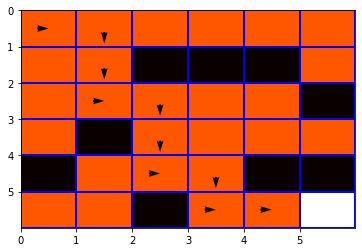

In [50]:
import matplotlib.pyplot as plt

def arrow_position(location, arrow_direction):
    if arrow_direction == 'UP':
        correction = (.5, .3)
    elif arrow_direction == 'DOWN':
        correction = (.6, .3)
    elif arrow_direction == 'RIGHT':
        correction = (.4, .5)
    elif arrow_direction == 'LEFT':
        correction = (.6, .5)
    return (location[0]+correction[0],
            location[1]+correction[1])
fig, ax = plt.subplots()
plt.xlim(0,horizontal)
plt.ylim(vertical,0)
plt.pcolormesh(rewards,edgecolor='b',cmap=plt.cm.hot)
# plt.grid(True)
plt.xticks(np.arange(0, horizontal, 1.0))
plt.yticks(np.arange(0, vertical, 1.0))

locations = action_direction.keys()
for location in locations:
    arrow_direction = action_direction[location]
    x_pos, y_pos = arrow_position(location, arrow_direction)
    x_direct, y_direct = direction_map[arrow_direction]
    ax.quiver(
        y_pos,x_pos,
        y_direct,x_direct,
        scale=30)

plt.show()